# SIMO for Ground Motion Events

In [1]:
import ssid
from ssid import modal, spec
import sdof
import numpy as np
from numpy import linspace, sqrt, pi
from ssid.utilities.config import Config
from ssid.utilities.printing import *
from ssid.numerics import decimate

## Unknown multi-input, multi-output system
parameter | value
----------|-------
$m_{1}$  | mass at dof 1
$m_{2}$  | mass at dof 2
$k_{1}$  | stiffness at dof 1
$k_{2}$  | stiffness at dof 2
$c_{1}$  | damping at dof 1
$c_{2}$  | damping at dof 2
$\omega_{1}$  | natural periods for mode 1
$\omega_{2}$  | natural periods for mode 2
$\zeta_{1}$  | modal damping for mode 1
$\zeta_{2}$  | modal damping for mode 2 2

![2dof](./figures/2dof.png)

$$a = \frac{m_{1}}{m_{2}}$$
$$b = \frac{k_{1}}{k_{2}}$$

$$\mathbf{M} = \begin{bmatrix} m_{1} & 0 \\ 0 & m_{2} \end{bmatrix} = m_{2}\begin{bmatrix} a & 0 \\ 0 & 1 \end{bmatrix}$$

$$\mathbf{K} = \begin{bmatrix} k_{1}+k_{2} & -k_{2} \\ -k_{2} & k_{2} \end{bmatrix} = k_{2} \begin{bmatrix} 1+b & -1 \\ -1 & 1 \end{bmatrix}$$

$$\mathbf{M}^{-1}\mathbf{K} = \frac{k_{2}}{am_{2}}\begin{bmatrix} 1+b & -1 \\ -a & a \end{bmatrix}$$

$$(1+b-\lambda)(a-\lambda)+a = 0$$
$$\lambda^{2}+(-b-a{m}-1)\lambda+2a+ab = 0$$

$$ \mathbf{M\ddot{u}} + \mathbf{Ku} = \mathbf{f(t)} $$

$$ \mathbf{\ddot{u}}  + \mathbf{M^{-1}Ku} = \mathbf{M^{-1}f(t)}  $$

$$ \mathbf{u} =  \Phi \mathbf{q}, \hspace{1cm} \mathbf{M^{-1}K} = \Phi\Lambda\Phi^{-1}  $$

$$ \mathbf{\ddot{u}}  + \mathbf{M^{-1}Ku} = \mathbf{M^{-1}f(t)}  $$

$$ \mathbf{\ddot{u}}  + \Phi\Lambda\Phi^{-1}\mathbf{u} = \mathbf{M^{-1}f(t)}  $$

$$ \Phi^{-1}\mathbf{\ddot{u}}  + \Phi^{-1}\Phi\Lambda\Phi^{-1}\mathbf{u} = \Phi^{-1}\mathbf{M^{-1}f(t)}  $$

$$ \mathbf{\ddot{q}}  + \Lambda\mathbf{q} = \Phi^{-1}\mathbf{M^{-1}f(t)}  $$

In [2]:
# get modal coordinates
def diag2dof(m1, m2, k1, k2):
  m = m2
  k = k2
  a = m1/m2
  b = k1/k2
  kab1 = k*(a + b + 1)/(2*a*m)
  ksqr = k*sqrt(a**2 - 2*a*b + 2*a + b**2 + 2*b + 1)/(2*a*m)
  eigvals = np.array([kab1 - ksqr,  kab1 + ksqr])
  eigvecs = np.array([[1 - m*(kab1 - ksqr)/k,   1 - m*(kab1 + ksqr)/k],
                      [1, 1]])  
  return eigvals, eigvecs

# displacement response (analytical solution) (output)
def harmonic_sdof(forcing_frequencies, nt, t, k, omega_n, zeta):
  omega_D = omega_n*np.sqrt(1-zeta**2)
  output = np.zeros((len(forcing_frequencies),nt))
  for i,omega in enumerate(forcing_frequencies):
    C3 = (1/k)*(1-(omega/omega_n)**2)/((1-(omega/omega_n)**2)**2+(2*zeta*omega/omega_n))**2
    C4 = -(2*zeta*omega/omega_n)*(1-(omega/omega_n)**2)/((1-(omega/omega_n)**2)**2+(2*zeta*omega/omega_n))**2
    C1 = -C4
    C2 = (zeta*omega_n*C1-omega*C3)/omega_D
    output[i,:] = np.exp(-zeta*omega_n*t)*(C1*np.cos(omega_D*t)+C2*np.sin(omega_D*t)) + C3*np.sin(omega*t) + C4*np.cos(omega*t)
  output = np.sum(output,axis=0)
  return output

def harmonic_2dof(forcing_frequencies, nt, t, m1, m2, k1, k2, zeta1, zeta2):
  ks = [k1, k2]
  zs = [zeta1, zeta2]
  omega_ns, phis = diag2dof(m1, m2, k1, k2)
  outputs = np.empty((2,nt))
  for i in range(2):
    outputs[i] = harmonic_sdof(forcing_frequencies, nt, t, ks[i], omega_ns[i], zs[i])
  outputs = phis@outputs
  return omega_ns, phis, outputs

In [3]:
# parameters of 2DOF system
m1 = 2          # mass
m2 = 1          # mass
ms = [m1, m2]
k1 = 30         # stiffness
k2 = 10         # stiffness
ks = [k1, k2]
zeta1 = 0.01    # damping ratio
zeta2 = 0.02    # damping ratio
zetas = [zeta1, zeta2]

omega_ns, phis = diag2dof(*ms, *ks)

C = phis @ np.diag([2*zeta*omega_n for zeta,omega_n in zip(zetas, omega_ns)])   # damping coefficients
                    
Tns = [2*np.pi/omega_n for omega_n in omega_ns]
print(f"natural periods: {Tns[0]:<3.3}s, {Tns[1]:<3.3}s")
print(f"damping ratios: {zeta1}, {zeta2}")

C

natural periods: 0.991s, 0.266s
damping ratios: 0.01, 0.02


array([[ 0.04641016, -1.29282032],
       [ 0.12679492,  0.94641016]])

In [4]:
# forcing function (input)
nt = 5000       # number of timesteps
dt = 0.03       # timestep
tf = nt*dt      # final time
t = np.arange(start = 0, stop = tf, step = dt)  # times
forcing_frequencies = [0.017*omega_ns[0], 0.14*omega_ns[0], 0.467*omega_ns[0], 0.186*omega_ns[0], 0.2937*omega_ns[0]]  # forcing frequencies (rad/s)
inputs = np.sum(np.sin([omega*t for omega in forcing_frequencies]), axis=0)

In [5]:
# displacement response (output)
_, _, outputs = harmonic_2dof(forcing_frequencies, nt, t, *ms, *ks, *zetas)

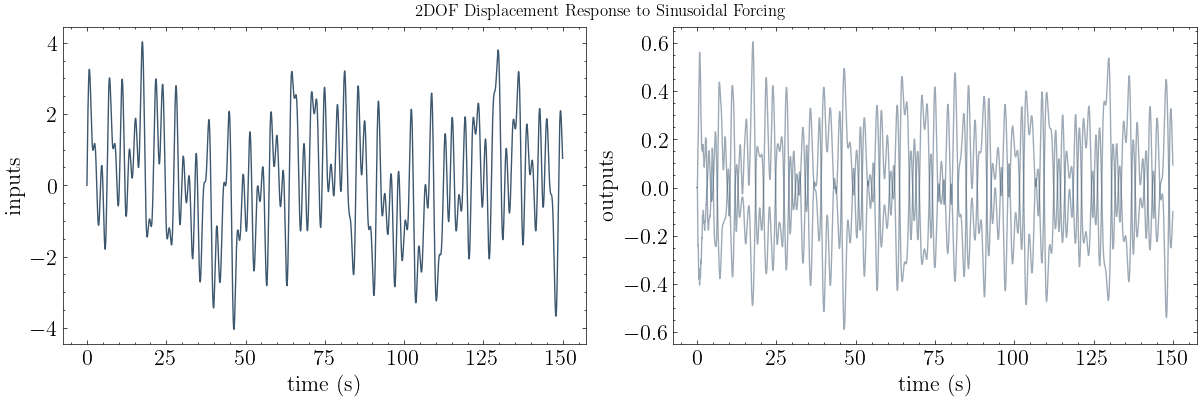

In [6]:
# plot input vs. output
plot_io(inputs=inputs, outputs=outputs, t=t, title="2DOF Displacement Response to Sinusoidal Forcing")

## Configure

#### Method

In [7]:
conf = Config()
conf.r = 8
conf.decimation = 1

## Analysis with System Identification

#### Transfer Function Methods

100%|█████████▉| 2200/2201 [00:00<00:00, 3869.26it/s]
/mnt/c/Users/cmp/Documents/GitHub/SystemIdentification/src/ssid/validation.py:137: RuntimeWarning: divide by zero encountered in scalar divide
  nu[i]    = (s22[i]-s11[i])/(2*s12[i])
/mnt/c/Users/cmp/Documents/GitHub/SystemIdentification/src/ssid/validation.py:138: RuntimeWarning: invalid value encountered in scalar multiply
  lam[0,i] = (s11[i]+s22[i])/2 + s12[i]*np.sqrt(nu[i]**2+1)
/mnt/c/Users/cmp/Documents/GitHub/SystemIdentification/src/ssid/validation.py:139: RuntimeWarning: invalid value encountered in scalar multiply
  lam[1,i] = (s11[i]+s22[i])/2 - s12[i]*np.sqrt(nu[i]**2+1)


[0.2655586578711061, 0.991078403564804, 2.589501843696377]


ValueError: setting an array element with a sequence.

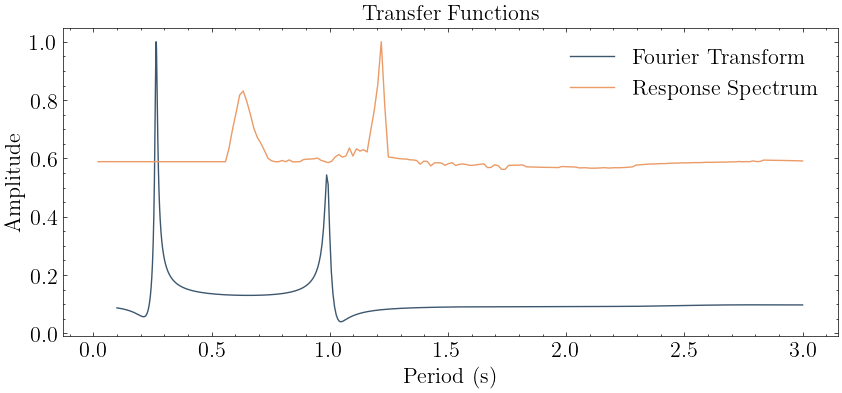

In [8]:
# Set parameters
conf.damping = zetas[0]
conf.period_band = (0.1,3) # Period band (s)
conf.pseudo = True # use pseudo accelerations (Sa)

# A place to store models and their predictions
transfer_models = {}

# Generate a transfer function representation of the system
transfer_models["Fourier Transform"] = spec.fourier_transfer(inputs, outputs[0], dt, **conf)
transfer_models["Response Spectrum"] = spec.response_transfer(inputs, outputs[0], dt, **conf)
plot_transfer(transfer_models, title="Transfer Functions")

# Determing the fundamental frequency
fundamental_fourier = modal.spectrum_modes(*transfer_models["Fourier Transform"])
fundamental_response = modal.spectrum_modes(*transfer_models["Response Spectrum"])


# Generate a state space realization of the system
conf.decimation = 2
realization = ssid.system(method="srim", inputs=inputs, outputs=outputs, **conf)
# Obtain natural period and damping ratio from the state space model
ss_modes = modal.system_modes(realization, dt, **conf)
ss_periods = [1/f for f in [ss_modes[mode]["freq"] for mode in ss_modes.keys()]]
print(ss_periods)
# print_modes(ss_modes, Tn=Tn, zeta=zeta)

plt.gcf().axes[0].vlines([fundamental_fourier[0], fundamental_response[0]],ymin=[0,0],ymax=[fundamental_fourier[1],fundamental_response[1]],linestyles='--',colors='k')
plt.gcf().axes[0].vlines(ss_periods,0,max(fundamental_fourier[1],fundamental_response[1]),linestyles='--',colors='r',label='State Space')
plt.gcf().axes[0].legend()
plt.gcf().axes[0].text(fundamental_fourier[0],fundamental_fourier[1],r"$T_{1}$ = "+str(np.round(fundamental_fourier[0][0],3)))
plt.gcf().axes[0].text(fundamental_response[0],fundamental_response[1],r"$T_{1}$ = "+str(np.round(fundamental_response[0][0],3)));

#### State Space ("Parametric") Methods

In [ ]:
# Generate a state space realization of the system
conf.decimation = 2
realization = ssid.system(method="okid-era-dc", inputs=inputs, outputs=outputs, **conf)
# Obtain natural period and damping ratio from the state space model
ss_modes = modal.system_modes(realization, dt, **conf)
ss_periods = [1/f for f in [ss_modes[mode]["freq"] for mode in ss_modes.keys()]]
print(ss_periods)
# print_modes(ss_modes, Tn=Tn, zeta=zeta)

[1.0025200636857887, 1.3607875380443741, 2.5390363420961104]


In [ ]:
# Generate a state space realization of the system
conf.decimation = 2
realization = ssid.system(method="srim", inputs=inputs, outputs=outputs, **conf)
# Obtain natural period and damping ratio from the state space model
ss_modes = modal.system_modes(realization, dt, **conf)
ss_periods = [1/f for f in [ss_modes[mode]["freq"] for mode in ss_modes.keys()]]
print(ss_periods)
# print_modes(ss_modes, Tn=Tn, zeta=zeta)

100%|█████████▉| 2200/2201 [00:00<00:00, 5557.75it/s]

[0.2655586578711061, 0.991078403564804, 2.589501843696377]


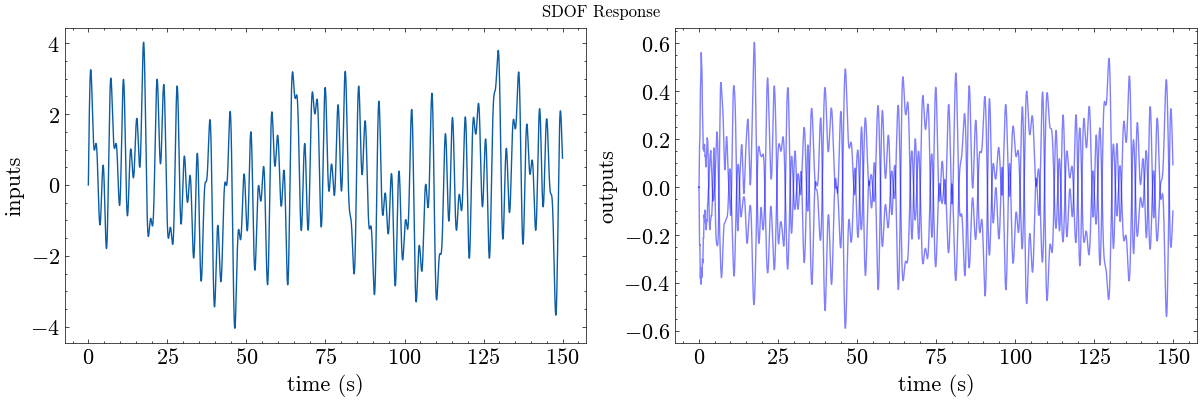

In [ ]:
plot_io(inputs=inputs, outputs=outputs, t=t, title="SDOF Response")

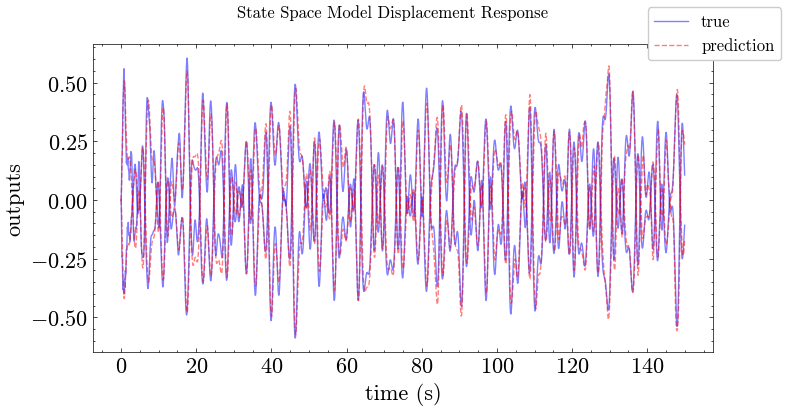

In [ ]:
# Reproduce the response with the state space model
from control import ss, forced_response
out_ssid = forced_response(ss(*realization,dt*conf.decimation), U=decimate(inputs,conf.decimation), squeeze=False, return_x=False).outputs
plot_pred(ytrue=decimate(outputs,conf.decimation), models=out_ssid, t=decimate(t,conf.decimation), title="State Space Model Displacement Response")